<font size=6><b> Stock Prediction (LSTM)

In [1]:
# ! pip install pandas_datareader
# ! pip install yfinance
# ! pip install plotly

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
# import os
# print(os.listdir("../input"))

import matplotlib.pyplot as plt
import seaborn as sns
#------------------------------------ 금융차트 --------------------
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

#------------------------------------ 금융 --------------------
from pandas_datareader.data import DataReader
import yfinance as yf

#------------------------------------ 전처리 --------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

#------------------------------------ MODEL --------------------
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model, load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization ,  Flatten, LSTM, GRU
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint


#------------------------------------ STAT. --------------------
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


import warnings
warnings.filterwarnings(action='ignore')

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

sns.set()

In [3]:
import matplotlib.font_manager as fm
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams["figure.figsize"] = (8,4)
mpl.rcParams['axes.grid'] = True 
path = 'C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
# plt.title('한글제목')
# plt.show()

NanumGothic


# Data Load

In [4]:
df = pd.read_csv("./AT_train.csv", parse_dates=['date'])
df = df.set_index('date')
# df['요일'].unique()
df['요일'] = df['요일'].replace(['월요일', '화요일', '수요일', '목요일','금요일', '토요일', '일요일' ],[0,1,2,3,4,5,6])
df.head()

,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),건고추_거래량(kg),건고추_가격(원/kg),마늘_거래량(kg),마늘_가격(원/kg),대파_거래량(kg),대파_가격(원/kg),얼갈이배추_거래량(kg),얼갈이배추_가격(원/kg),양배추_거래량(kg),양배추_가격(원/kg),깻잎_거래량(kg),깻잎_가격(원/kg),시금치_거래량(kg),시금치_가격(원/kg),미나리_거래량(kg),미나리_가격(원/kg),당근_거래량(kg),당근_가격(원/kg),파프리카_거래량(kg),파프리카_가격(원/kg),새송이_거래량(kg),새송이_가격(원/kg),팽이버섯_거래량(kg),팽이버섯_가격(원/kg),토마토_거래량(kg),토마토_가격(원/kg),청상추_거래량(kg),청상추_가격(원/kg),백다다기_거래량(kg),백다다기_가격(원/kg),애호박_거래량(kg),애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-02,5,80860.0,329.0,80272.0,360.0,122787.5,1281.0,3.0,11000.0,15019.0,5475.0,92334.0,1704.0,6359.0,1331.0,40028.0,348.0,4374.9,13242.0,16550.5,2339.0,10528.0,1729.0,13885.0,804.0,3853.0,3703.0,15797.0,2576.0,14634.0,1474.0,30950.0,1621.0,5125.0,9235.0,434.0,2109.0,19159.0,2414.0,880.0,2014.0,0.0,0.0
2016-01-03,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-04,0,1422742.5,478.0,1699653.7,382.0,2315079.0,1235.0,699.0,4464.0,141638.0,5210.0,994328.1,1716.0,262615.5,1212.0,1074699.1,345.0,122613.5,9923.0,427435.1,2153.0,82113.5,3960.0,558950.2,794.0,104930.3,4871.0,277326.5,2440.0,159800.0,1750.0,291057.0,1834.0,38525.5,7631.0,500702.0,2046.0,620539.0,2018.0,2703.8,3885.0,0.0,0.0
2016-01-05,1,1167241.0,442.0,1423482.3,422.0,2092960.1,1213.0,1112.6,4342.0,126207.8,5387.0,787716.0,1715.0,221850.5,1197.0,825681.9,350.0,79055.9,9529.0,334636.8,2220.0,80144.0,3333.0,444353.7,763.0,100699.5,5129.0,218465.2,2437.0,153084.0,1822.0,194626.5,1833.0,32615.0,6926.0,147638.0,2268.0,231958.0,2178.0,8810.0,2853.0,0.0,0.0


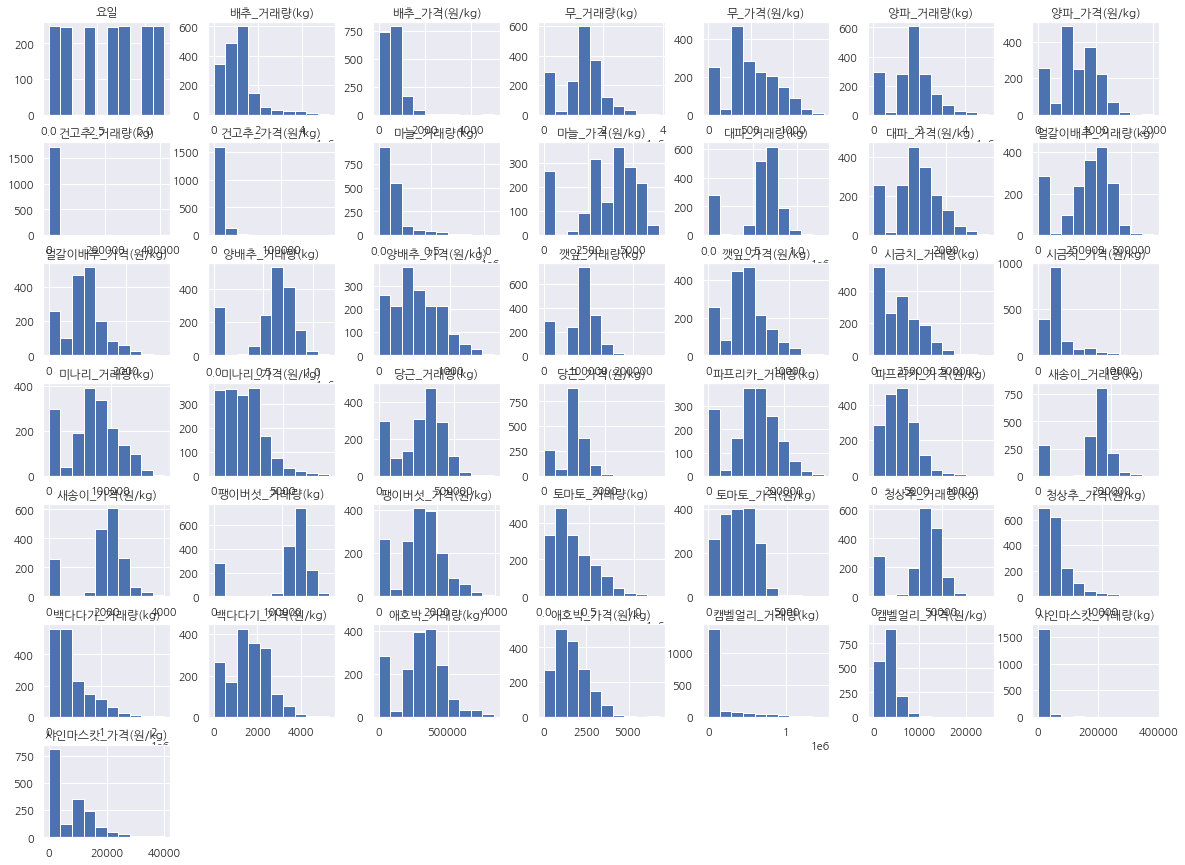

In [5]:
df.hist(figsize=(20,15))
plt.show()

In [6]:
df.columns = df.columns.str.replace(r'\([^)]*\)','', regex=True)
df.columns

Index(['요일', '배추_거래량', '배추_가격', '무_거래량', '무_가격', '양파_거래량', '양파_가격', '건고추_거래량',
       '건고추_가격', '마늘_거래량', '마늘_가격', '대파_거래량', '대파_가격', '얼갈이배추_거래량', '얼갈이배추_가격',
       '양배추_거래량', '양배추_가격', '깻잎_거래량', '깻잎_가격', '시금치_거래량', '시금치_가격', '미나리_거래량',
       '미나리_가격', '당근_거래량', '당근_가격', '파프리카_거래량', '파프리카_가격', '새송이_거래량', '새송이_가격',
       '팽이버섯_거래량', '팽이버섯_가격', '토마토_거래량', '토마토_가격', '청상추_거래량', '청상추_가격',
       '백다다기_거래량', '백다다기_가격', '애호박_거래량', '애호박_가격', '캠벨얼리_거래량', '캠벨얼리_가격',
       '샤인마스캇_거래량', '샤인마스캇_가격'],
      dtype='object')

In [7]:
target_list = df.columns.str.replace(r'\_[^)]*','', regex=True).unique().values
target_list

array(['요일', '배추', '무', '양파', '건고추', '마늘', '대파', '얼갈이배추', '양배추', '깻잎',
       '시금치', '미나리', '당근', '파프리카', '새송이', '팽이버섯', '토마토', '청상추', '백다다기',
       '애호박', '캠벨얼리', '샤인마스캇'], dtype=object)

In [8]:
col_list_p = df.columns[df.columns.str.contains('가격' ) == True]
col_list_v = df.columns[df.columns.str.contains('거래량' ) == True]

In [9]:
p_desc = df[col_list_p].describe().reset_index()
v_desc = df[col_list_v].describe().reset_index()
v_desc

,index,배추_거래량,무_거래량,양파_거래량,건고추_거래량,마늘_거래량,대파_거래량,얼갈이배추_거래량,양배추_거래량,깻잎_거래량,시금치_거래량,미나리_거래량,당근_거래량,파프리카_거래량,새송이_거래량,팽이버섯_거래량,토마토_거래량,청상추_거래량,백다다기_거래량,애호박_거래량,캠벨얼리_거래량,샤인마스캇_거래량
0,count,1.733000e+03,1.733000e+03,1.733000e+03,1733.000000,1.733000e+03,1.733000e+03,1733.000000,1.733000e+03,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1.733000e+03,1733.000000,1.733000e+03,1733.000000,1.733000e+03,1733.000000
1,mean,1.113022e+06,1.274344e+06,1.656628e+06,3578.541546,1.383455e+05,5.705150e+05,256330.243566,5.626202e+05,80191.161281,151690.438777,70430.079227,275135.965609,116573.645759,144348.644432,104171.368090,3.190970e+05,34706.229948,4.234344e+05,302488.655857,1.183558e+05,6690.233756
2,std,8.376334e+05,7.065624e+05,9.506928e+05,24139.188640,1.431412e+05,2.710508e+05,135087.466528,2.762762e+05,40646.588418,123432.803489,41665.404676,154303.528548,66032.314912,67150.304712,47220.947213,2.398657e+05,16709.614996,3.704087e+05,172693.828603,2.465254e+05,24296.175358
3,min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
4,25%,6.892023e+05,1.008677e+06,1.334250e+06,129.100000,7.392050e+04,5.523516e+05,198110.500000,5.229527e+05,71171.300000,35381.000000,49765.500000,180390.000000,86782.200000,148291.800000,109745.000000,1.622534e+05,32331.200000,1.871330e+05,224225.700000,9.742000e+02,0.000000
5,50%,1.061471e+06,1.374790e+06,1.703356e+06,544.200000,1.040097e+05,6.485427e+05,289685.000000,6.436717e+05,88550.900000,139586.400000,72715.600000,311458.000000,124327.700000,164255.900000,121304.200000,2.716132e+05,39359.400000,3.218295e+05,320756.000000,4.541600e+03,126.000000
6,75%,1.385737e+06,1.661663e+06,2.143338e+06,1753.000000,1.533750e+05,7.282878e+05,354815.400000,7.347380e+05,103722.000000,241679.200000,97896.400000,382007.200000,159794.500000,178620.000000,130877.000000,4.643230e+05,44789.800000,5.951962e+05,409689.000000,7.459400e+04,2782.000000
7,max,5.210215e+06,3.859746e+06,5.024753e+06,413656.000000,1.092180e+06,1.302729e+06,618133.300000,1.165192e+06,256450.400000,666537.200000,187230.400000,764860.600000,307079.200000,315101.700000,169256.000000,1.279844e+06,84155.000000,2.202192e+06,831849.000000,1.490337e+06,382263.400000


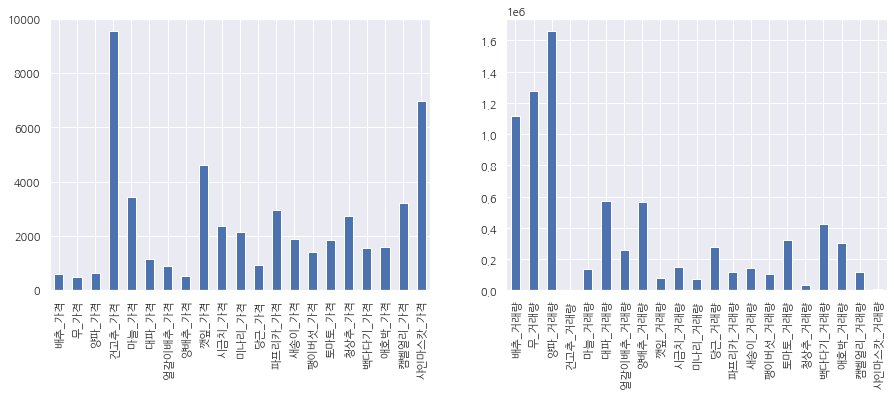

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
p_desc.iloc[1, 1:].plot.bar()
plt.subplot(1,2,2)
v_desc.iloc[1, 1:].plot.bar()
plt.show()

In [11]:
# cols = ['','']
# fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
# for i in range(len(cols)):
#     col = cols[i]
#     r = i//3
#     c = i%3
#     sns.boxplot(x="type",     y=col, data=df, hue='gubun', ax=axes[r][c])
# plt.show()
# plt.close()

* 건고추, 시금치, 청상추, '캠벨얼리', '샤인마스캇'

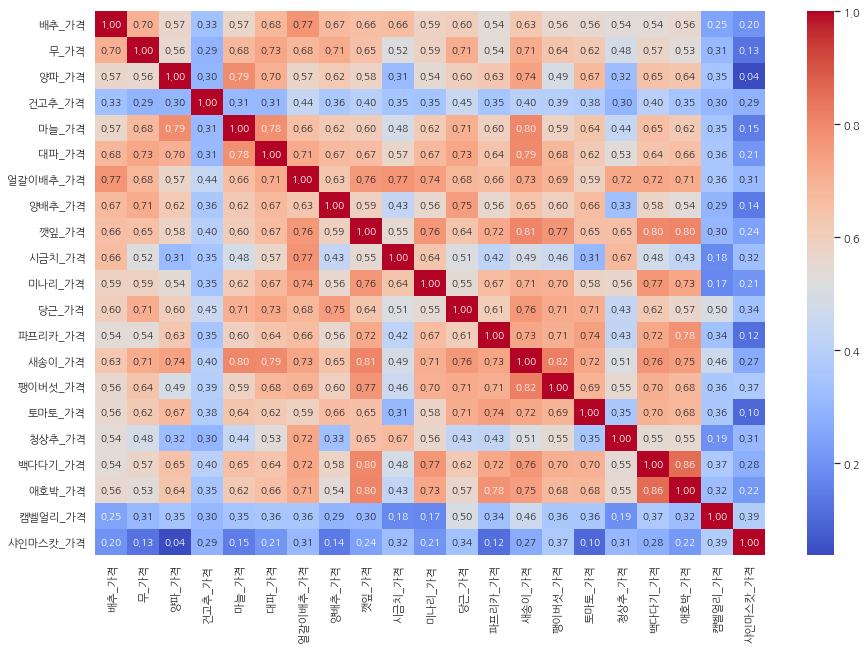

In [12]:
plt.figure(figsize = (15,10))
sns.heatmap(df[col_list_p].corr(), fmt=".2f", annot=True, cmap="coolwarm")
plt.show()           

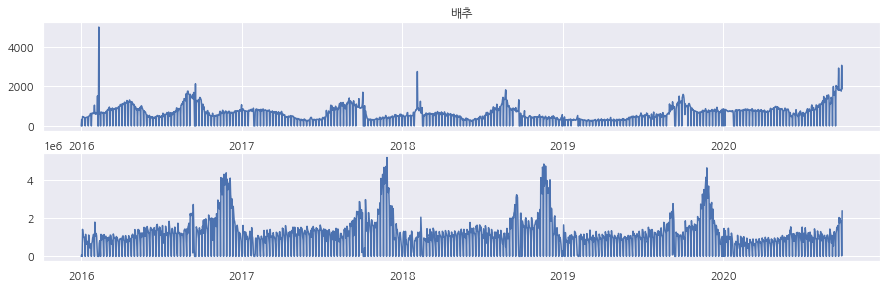

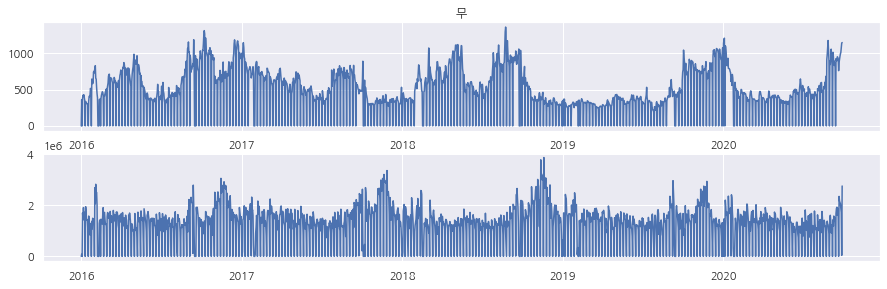

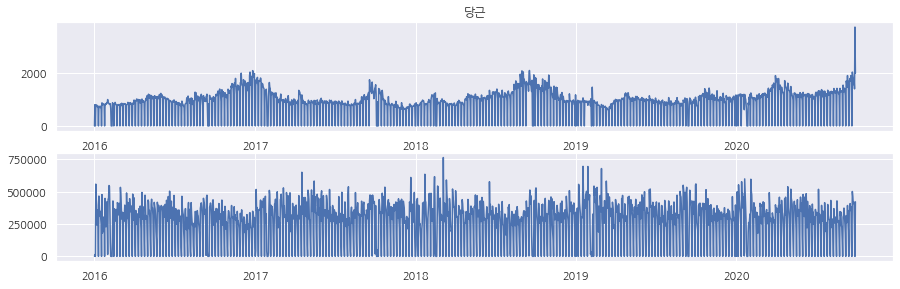

In [13]:
temp = ['배추','무','당근']
for i, col in enumerate(temp):
    plt.figure(figsize=(15,14))
    plt.subplot(len(temp)*2,1,i+1)
    plt.plot(df.index, df[f"{col}_가격"])
    plt.title(f'{col}')
    plt.subplot(6,1,i+2)
    plt.plot(df.index, df[f"{col}_거래량"])
plt.show()

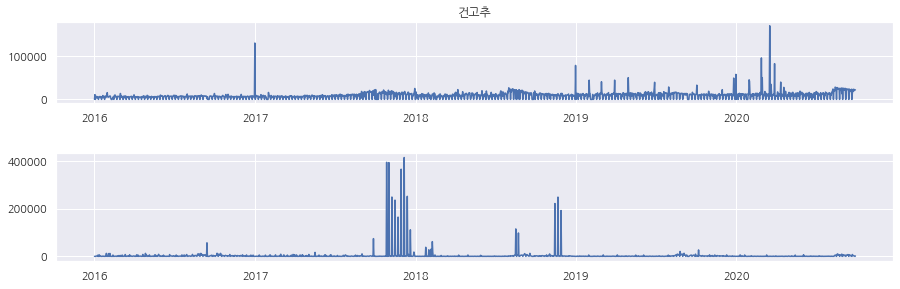

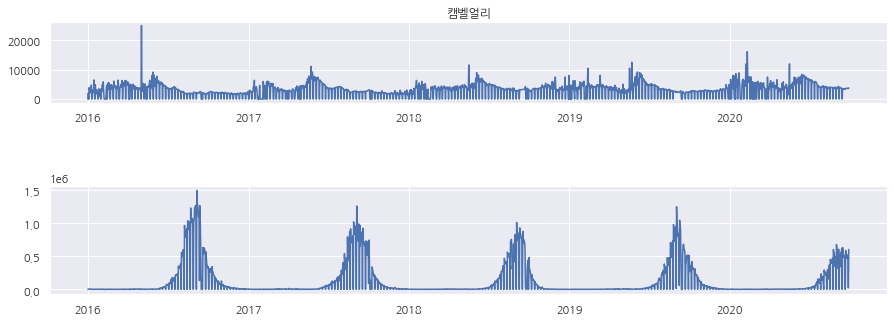

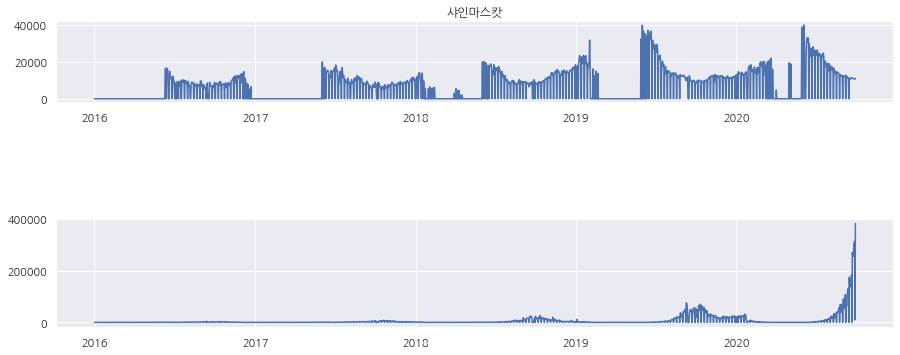

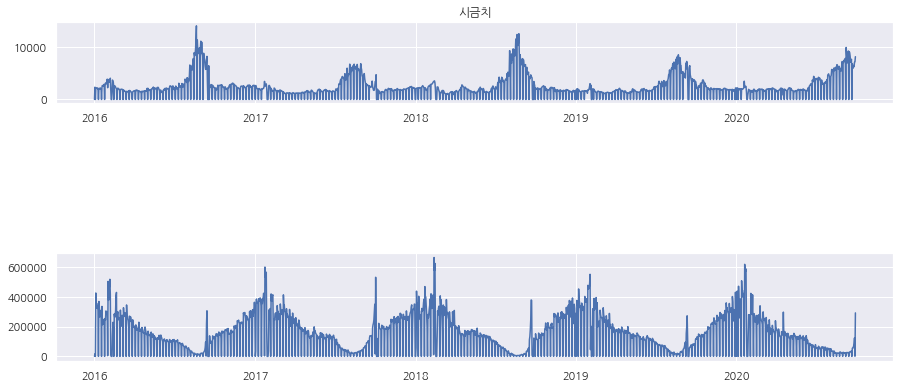

In [15]:
temp = ['건고추', '캠벨얼리', '샤인마스캇','시금치']
for i, col in enumerate(temp):
    plt.figure(figsize=(15,14))
    plt.subplot(len(temp)*2,1,i+1)
    plt.plot(df.index, df[f"{col}_가격"])
    plt.title(f'{col}')
    plt.subplot(6,1,i+2)
    plt.plot(df.index, df[f"{col}_거래량"])
plt.show()


In [16]:
dfcp = df[['배추_가격','배추_거래량']].copy()
dfcp.columns = ['price', 'volume']
dfcp.head(20)

,price,volume
date,,
2016-01-01,0.0,0.0
2016-01-02,329.0,80860.0
2016-01-03,0.0,0.0
2016-01-04,478.0,1422742.5
2016-01-05,442.0,1167241.0
2016-01-06,442.0,1045507.5
2016-01-07,448.0,1039925.0
2016-01-08,420.0,942655.0
2016-01-09,389.0,689121.0


In [17]:
idx0 = dfcp[dfcp['price']==0.0].index
dfcp.drop(idx0, inplace=True)

In [18]:
dfcp.head(10)

,price,volume
date,,
2016-01-02,329.0,80860.0
2016-01-04,478.0,1422742.5
2016-01-05,442.0,1167241.0
2016-01-06,442.0,1045507.5
2016-01-07,448.0,1039925.0
2016-01-08,420.0,942655.0
2016-01-09,389.0,689121.0
2016-01-11,398.0,1161028.0
2016-01-12,431.0,730460.1


<AxesSubplot:>

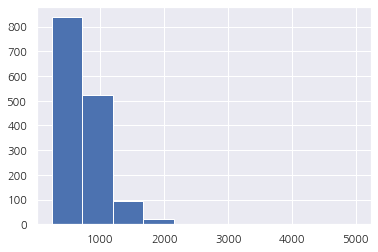

In [19]:
dfcp['price'].hist()

<AxesSubplot:>

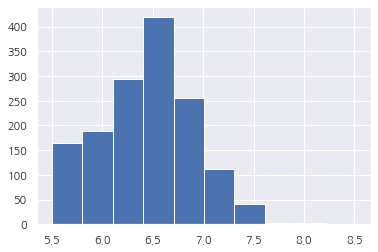

In [20]:
np.log1p(dfcp['price']).hist()

# 정상성(stationary) 체크
* rolling statistics plots 
* Dickey-Fuller test (대립 가설: 모델은 정상성을 띤다)

In [21]:
n_steps = 24
n_features = 1

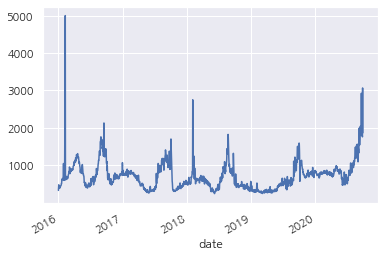

In [22]:
dfcp['price'].plot()
plt.show()

In [23]:
def my_check_stationarity(timeseries_df, n_steps=24):
    # rolling : mean, std ------------------------------------------
    rolmean = timeseries_df.rolling(24).mean()
    rolstd = timeseries_df.rolling(24).std()
    orig = plt.plot(timeseries_df, color='blue',label='original')
    mean = plt.plot(rolmean, color='red', label='rolling mean')
    std  = plt.plot(rolstd, color='black', label = 'rolling std')
    plt.legend()
    plt.title('rolling mean , std')
    plt.show(block=False)

    
    # Dickey-Fuller test ------------------------------------------
    print('Dickey-Fuller test:')
    dkf_test = adfuller(timeseries_df, autolag='AIC')
    dkf_test_res = pd.Series(dkf_test[0:4], index=['Test Statistic','p-value', '#Lags Used','Number of Observations Used'])
    for key,value in dkf_test[4].items():
        dkf_test_res['Critical Value (%s)'%key] = value
    print(dkf_test_res)

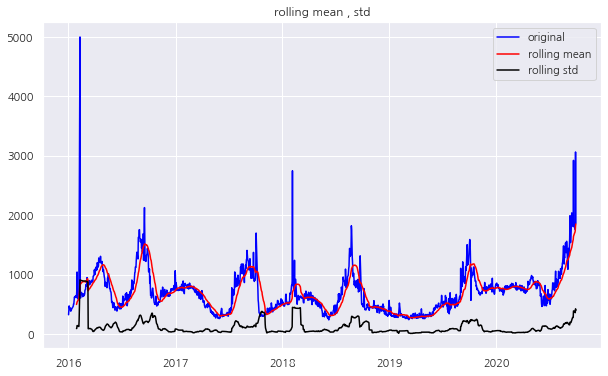

Dickey-Fuller test:
Test Statistic                   -2.351309
p-value                           0.155953
#Lags Used                        6.000000
Number of Observations Used    1473.000000
Critical Value (1%)              -3.434797
Critical Value (5%)              -2.863504
Critical Value (10%)             -2.567816
dtype: float64


In [24]:
plt.figure(figsize = (10,6))
my_check_stationarity(dfcp['price'])

<pre><font color=red><b>
* rolling mean 증가 : 비정상성
* p-value(0.813738) > 0.05     : 귀무가설(모델은 정상성을 띠지 않는다) 채택

# 시계열데이터 분해(decompose) 
<font color=red><b>정상성 데이터 만들기</b></font>
* trend, seasonality , cycles, residual, etc
* 분산이 큰경우 : log변환, 제곱근변환
* 평균이 일정하지 않은 경우 : 차분


<Figure size 432x288 with 0 Axes>

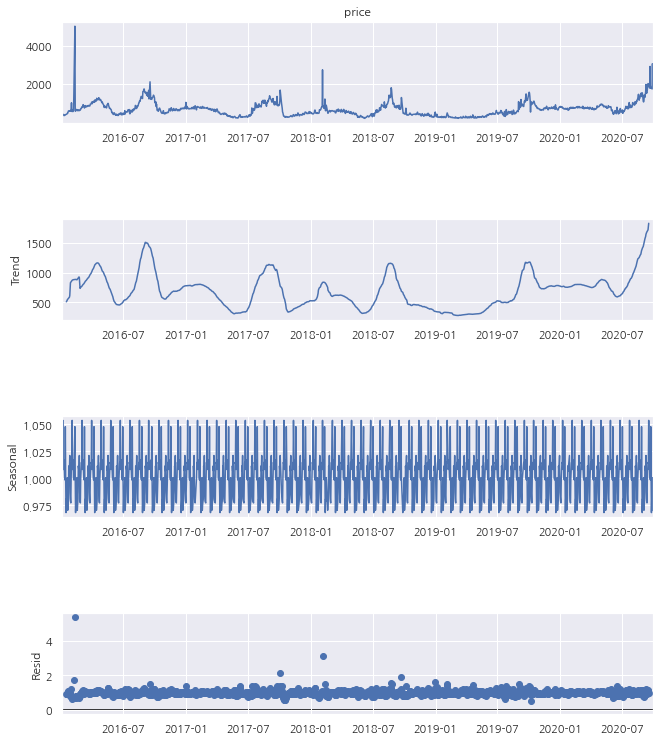

In [25]:
result = seasonal_decompose(dfcp['price'], model='multiplicative',period=n_steps)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 12)
plt.show()

## 분산 : 로그변환, 제곱근변환

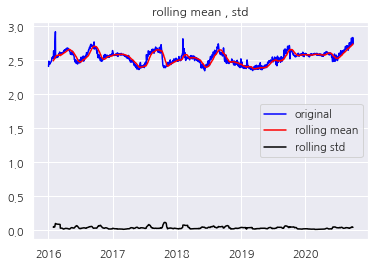

Dickey-Fuller test:
Test Statistic                   -2.486448
p-value                           0.118807
#Lags Used                        5.000000
Number of Observations Used    1474.000000
Critical Value (1%)              -3.434794
Critical Value (5%)              -2.863503
Critical Value (10%)             -2.567815
dtype: float64


In [26]:
df_price_log = dfcp['price'].apply(np.log)
# df_price_df = df_price_log.apply(np.sqrt)
my_check_stationarity(df_price_df)

<pre><font color=red><b>
* rolling mean 증가 : 비정상성
* p-value(0.118807) > 0.05     : 귀무가설(모델은 정상성을 띠지 않는다) 채택

## 평균 : 차분

In [27]:
df_price_shift = df_price_df - df_price_df.shift()
df_price_shift.head()

date
2016-01-02         NaN
2016-01-04    0.076370
2016-01-05   -0.015812
2016-01-06    0.000000
2016-01-07    0.002730
Name: price, dtype: float64

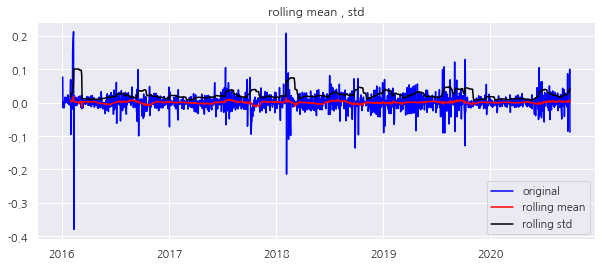

Dickey-Fuller test:
Test Statistic                  -22.264317
p-value                           0.000000
#Lags Used                        4.000000
Number of Observations Used    1474.000000
Critical Value (1%)              -3.434794
Critical Value (5%)              -2.863503
Critical Value (10%)             -2.567815
dtype: float64


In [28]:
df_price_shift.dropna(inplace=True)
plt.figure(figsize = (10,4))
my_check_stationarity(df_price_shift)

<pre><font color=red><b>
* rolling mean 증가 : 정상성
* p-value(0.000000) < 0.05     : 귀무가설(모델은 정상성을 띠지 않는다) 기각 , 대립가설(모델은 정상성을 띤다) 채택

# LSTM 모델
* Recurrent Neural Network (RNN) 모델<br><br>
<font color=red><b><pre>
Input : [1,2,3,4......240]
X     : [1,2,3...24], [25,26,...48], [49,50....72], ...
y     : [25,49,73,...]
X_train.shape  : [samples, timesteps, features]  --> [row수, rolling window크기, feature수]
rolling window : 24일

## 데이터 shape 가공
<font color=red><b>X_train.shape : [samples, timesteps, features] 
    
<pre>
TimeseriesGenerator    
data : df['Open','High','Low','Close','Volume']
targets : data동일(인풋 그대로 예측)
stride : 1
length: The number of lag observations to use in the input portion of each sample
batch_size: The number of samples to return on each iteration 


* ref : https://github.com/keras-team/keras-docs-ko/blob/master/sources/preprocessing/sequence.md

In [29]:
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# train_gen = TimeseriesGenerator(df_price_shift, df_price_shift, length=1, batch_size=1)
# print(train_gen[0][0].shape)
# print(train_gen[0][1].shape)

In [30]:
df_price_shift[:5]

date
2016-01-04    0.076370
2016-01-05   -0.015812
2016-01-06    0.000000
2016-01-07    0.002730
2016-01-08   -0.013095
Name: price, dtype: float64

In [31]:
n_steps = 24
n_features = 1

In [46]:
def my_make_data_unitval(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
        
        
    return np.array(X), np.array(y)
 
X, y = my_make_data_unitval(df_price_shift, n_steps)

print(X.shape, y.shape)
for i in range(5):
    print(X[i], y[i])
    print("------------------")
    
# reshape : [samples, timesteps] --> [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
print(X.shape, y.shape)

(1455, 24) (1455,)
[ 0.0763698  -0.01581219  0.          0.00273006 -0.01309501 -0.01564887
  0.00467862  0.01622433 -0.00094441  0.00559639  0.00364013  0.00223962
  0.00912366  0.01467     0.          0.02282394  0.01749114 -0.00349551
  0.0081569  -0.0056081   0.0056081   0.00304276 -0.00801918  0.03121846] 0.06867399076237479
------------------
[-0.01581219  0.          0.00273006 -0.01309501 -0.01564887  0.00467862
  0.01622433 -0.00094441  0.00559639  0.00364013  0.00223962  0.00912366
  0.01467     0.          0.02282394  0.01749114 -0.00349551  0.0081569
 -0.0056081   0.0056081   0.00304276 -0.00801918  0.03121846  0.06867399] -0.09583884183823832
------------------
[ 0.          0.00273006 -0.01309501 -0.01564887  0.00467862  0.01622433
 -0.00094441  0.00559639  0.00364013  0.00223962  0.00912366  0.01467
  0.          0.02282394  0.01749114 -0.00349551  0.0081569  -0.0056081
  0.0056081   0.00304276 -0.00801918  0.03121846  0.06867399 -0.09583884] -0.013101984882194717
------

In [45]:
# valid_ratio = 10 
# test_radio = 10 
# def my_make_data_multival(dfcp, n_steps=24, n_feature=1):
#     data_raw = dfcp  #.as_matrix()
#     data = []
            
#     for index in range(len(data_raw) - n_steps): 
#         data.append(data_raw[index: index + n_steps])
    
#     data = np.array(data);
#     valid_set_size = int(np.round(valid_ratio/100 * data.shape[0]));  
#     test_set_size  = int(np.round(test_radio/100  * data.shape[0]));
#     train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
#     X_train = data[:train_set_size,:-1,:]
#     y_train = data[:train_set_size, -1,:]
    
#     X_val = data[train_set_size:train_set_size+valid_set_size,:-1,:]
#     y_val = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
#     X_test = data[train_set_size+valid_set_size:,:-1,:]
#     y_test = data[train_set_size+valid_set_size:,-1,:]
    
#     return [X_train, y_train, X_val, y_val, X_test, y_test]

# # train_generator = TimeseriesGenerator(X_train, y_train,
# #                                       length=24, 
# #                                       sampling_rate = 1,
# #                                       stride        = 1,
# #                                       batch_size    = 10)


# # ---------------------------------------------------------------------------------------------
# X_train, y_train, X_val, y_val, X_test, y_test = my_make_data_multival(df, n_steps)
# print('X_train.shape = ',X_train.shape)
# print('y_train.shape = ', y_train.shape)
# print('X_val.shape = ',X_val.shape)
# print('y_val.shape = ', y_val.shape)
# print('X_test.shape = ', X_test.shape)
# print('y_test.shape = ',y_test.shape)

X_train.shape =  (1367, 23, 43)
y_train.shape =  (1367, 43)
X_val.shape =  (171, 23, 43)
y_val.shape =  (171, 43)
X_test.shape =  (171, 23, 43)
y_test.shape =  (171, 43)


## train, test 분리

In [34]:
test_days = 365 
X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test   = X[-test_days:], y[-test_days:]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# (833, 60, 1) (833,) (365, 60, 1) (365,)  --------------------------------------------- (single feature - n_steps_out) 

(1090, 24, 1) (1090,) (365, 24, 1) (365,)


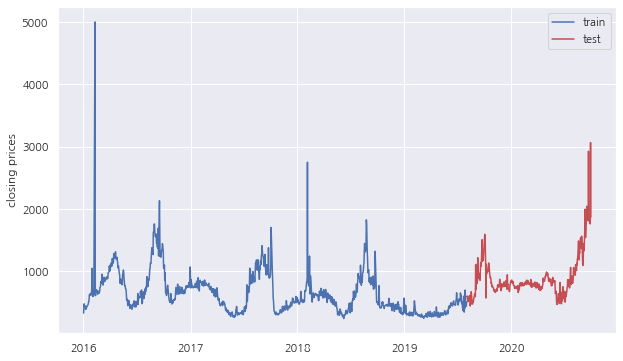

In [35]:
train_original = dfcp['price'].iloc[:-test_days]
test_original  = dfcp['price'].iloc[-test_days:]
plt.figure(figsize=(10,6))
plt.ylabel('closing prices')
plt.plot(train_original, 'b', label='train')
plt.plot(test_original, 'r',  label='test')
plt.legend()
plt.show()
plt.close()

## 모델 생성

In [36]:
model = Sequential()    
model.add(LSTM(units=50, input_shape=(n_steps, n_features)))
# model.add(Dense(1))       --------------------------------------------- (single feature)
model.add(Dense(1))
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.fit(X_train, 
          y_train, 
          epochs=15, 
          validation_split=0.1,
          batch_size = 32)

Epoch 1/15
31/31 [==============================] - 4s 35ms/step - loss: 8.4765e-04 - mean_absolute_error: 0.0170 - val_loss: 8.1639e-04 - val_mean_absolute_error: 0.0197
Epoch 2/15
31/31 [==============================] - 0s 14ms/step - loss: 8.2099e-04 - mean_absolute_error: 0.0168 - val_loss: 7.9565e-04 - val_mean_absolute_error: 0.0193
Epoch 3/15
31/31 [==============================] - 0s 15ms/step - loss: 8.0247e-04 - mean_absolute_error: 0.0166 - val_loss: 7.8784e-04 - val_mean_absolute_error: 0.0191
Epoch 4/15
31/31 [==============================] - 0s 11ms/step - loss: 7.9560e-04 - mean_absolute_error: 0.0168 - val_loss: 7.9955e-04 - val_mean_absolute_error: 0.0192
Epoch 5/15
31/31 [==============================] - 0s 12ms/step - loss: 7.7868e-04 - mean_absolute_error: 0.0166 - val_loss: 7.6819e-04 - val_mean_absolute_error: 0.0189
Epoch 6/15
31/31 [==============================] - 0s 12ms/step - loss: 7.7343e-04 - mean_absolute_error: 0.0166 - val_loss: 7.4042e-04 - val_me

In [38]:
mse, mae = model.evaluate(X_test, y_test, batch_size=32)
print(f"MSE: {mse}  MAE:{mae}")

# MSE: 5.954952212050557e-05  MAE:0.005700898356735706   ------------- (single feature)

12/12 [==============================] - 0s 4ms/step - loss: 5.1664e-04 - mean_absolute_error: 0.0147
MSE: 0.0005166397895663977  MAE:0.014662602916359901


## 예측

In [39]:
pred = model.predict(X_test)
pred[:5]

array([[ 0.00044581],
       [-0.00769233],
       [-0.00583448],
       [ 0.00447552],
       [ 0.00808616]], dtype=float32)

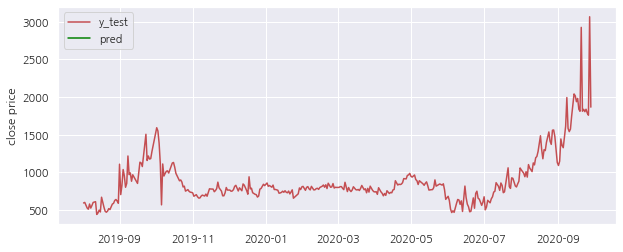

In [40]:


# Plot actual prices vs predicted prices 

pred_df = pd.DataFrame(pred[:,0],  test_original.index,  columns=['pred'])
pred_df['pred2'] = pred_df['pred'] + dfcp['price'].shift().values[-test_days:] 
pred_df = pred_df.apply(np.square)
pred_df = pred_df.apply(np.exp)

plt.figure(figsize=(10,4))
plt.ylabel('close price')
plt.plot(test_original     , 'r'     ,label='y_test')
plt.plot(pred_df['pred2']  , 'green' ,label='pred')
plt.legend()
plt.show()

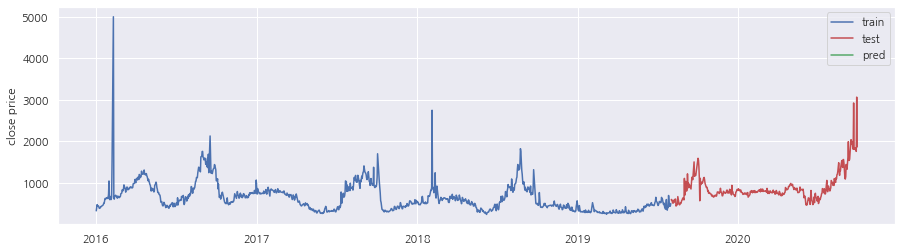

In [41]:
plt.figure(figsize=(15,4))
plt.ylabel('close price')
plt.plot(train_original   , 'b', label='train')
plt.plot(test_original    , 'r', label='test')
plt.plot(pred_df['pred2'] , 'g', label='pred')
plt.legend()
plt.show()

In [42]:
pred_df

,pred,pred2
date,,
2019-08-02,1.000000,inf
2019-08-03,1.000059,inf
2019-08-05,1.000034,inf
2019-08-06,1.000020,inf
2019-08-07,1.000065,inf
...,...,...
2020-09-24,1.000102,inf
2020-09-25,1.000051,inf
2020-09-26,1.000040,inf
